### get the correlation of peak changes and others

In [3]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggplot2)
    library(patchwork)
    library(parallel)
    library(patchwork)
    #library(customLayout)
    library(tidyverse)
    #library('spectral')
    #library('phonTools')
    library(ggrepel)
    library('gridGraphics')
    library('ggplotify')
    #library(ggfortify)
})


In [4]:
## function to set width and health
psize<-function(w=10,h=10){
  options(repr.plot.width = w, repr.plot.height = h)
}
restorePsize<-function(){
  options(repr.plot.width = 10, repr.plot.height = 10)
}

In [6]:
quantification_fun <- function(data,site='',kernel_weight=2000, 
                               sdev_weight = 1, ylim_=c(-1.5, 12), xmax_=10e5,
                               plot=TRUE,smooth_=FALSE,downsampling=FALSE){
    options(repr.plot.width = 10, repr.plot.height = 6)

    if(smooth_){
            data <- data%>%mutate(diff=smooth.spline(diff)$y, sdev=smooth.spline(sdev)$y)
       
    }
    data <- data%>%mutate(diff.aboveZero=ifelse(diff>0,diff,0))
    data <- data%>%mutate(diff.withconfidence0.95=ifelse( data$meanCPM-(data$ctlMean+sdev_weight*data$sdev )>0,data$diff,0))
    data <- data%>%mutate(weight=exp(-(abs(dist)/kernel_weight)),diff.0.95=meanCPM-(ctlMean+sdev_weight*sdev))%>%
            mutate(diff.correct = diff.0.95*weight)

    mean <- data%>%mutate(diff.correct.aboveZero=ifelse(diff.correct>0,diff.correct,0))%>%pull(diff.correct.aboveZero)%>%mean + 0.01
    data <- data%>%mutate(diff.correct.aboveZero=ifelse(diff.correct>0,diff.correct,0))%>%
    mutate(label=ifelse(diff.correct.aboveZero>mean,'blue','red'))#%>%pull(label)

    Peak.wide.max <- data%>%filter(label=='blue')%>%pull(dist)%>%max
    Peak.wide.min <- data%>%filter(label=='blue')%>%pull(dist)%>%min

    Peak.wideWidth <- Peak.wide.max-Peak.wide.min
    Peak.wideSum <- data%>%filter(label=='blue')%>%pull(diff)%>%sum


    control <- data%>%filter(abs(dist)>xmax_,diff.0.95>0)%>%pull((diff.0.95))%>%mean
    data <- data%>%mutate(label=(diff.correct>control))
    select <- data%>%filter(diff.correct>control)

    
    a <- data%>%mutate(#core.min=maxValue.narrow,core.max=minValue.narrow,
          base.min=Peak.wide.max,base.max=Peak.wide.min)
    if(plot){
        
        if(downsampling){
            a <- data%>%mutate(row_=row_number())%>%filter(row_%%100==0)
        }
        a <- a%>%mutate(diff.outInterval=ifelse(diff>0,ifelse(diff-sdev_weight*sdev>0,diff,NA),ifelse(diff+sdev_weight*sdev<0,diff,NA)))%>%
            mutate(diff.inInterval=ifelse(is.na(diff.outInterval),diff,NA))

        plot(a$dist, a$diff.outInterval,xlim=c(-xmax_,xmax_), cex = 1.5, col = '#D43F3AFF', xaxt='n', ylim = ylim_,
             xlab = "Distance (kb)", ylab = expression(paste(Delta,"Chromatin Accessibility")), type = "l", lwd = 2)
        lines(a$dist, a$diff.inInterval,lwd = 2,col = adjustcolor("red4", alpha.f = 0.3))
        
        axis(1, at=c(0,xmax_/2,-xmax_/2,xmax_,-xmax_), 
             labels=c('0',as.character(round(xmax_/2000)),as.character(round(-xmax_/2000)),
                      as.character(round(xmax_/1000)),as.character(round(-xmax_/1000))))
        title(main = site, line = 0.2)
        polygon(c(a$dist, rev(a$dist)), c(0 +  sdev_weight*a$sdev, rev(0 -sdev_weight*a$sdev)), col = adjustcolor("grey", alpha.f = 0.4), border = FALSE)
        lines(a$dist, 0 +  sdev_weight*a$sdev, lty = "dashed", col = adjustcolor("red", alpha.f = 0.2),lwd=1)
        lines(a$dist, 0 -  sdev_weight*a$sdev, lty = "dashed", col = adjustcolor("red", alpha.f = 0.2),lwd=1)


        abline(v=c(Peak.wide.max,Peak.wide.min),lty=2,col='deepskyblue')
        #grid.echo()

    }
    peak.info.list <- list(Peak.wideWidth=Peak.wideWidth,
                            Peak.wideSum=Peak.wideSum,
                            Peak.wide.min=Peak.wide.min,
                            Peak.wide.max=Peak.wide.max)
    return (peak.info.list)

}

# HEK293

In [9]:
cutSite.mat.step1 <- readRDS('demo_data/cutSite.mat.293t.example.rds')

In [ ]:
t2 <- list()
for(i in names(cutSite.mat.step1)){
    a <-  quantification_fun(cutSite.mat.step1[[i]],i,kernel_weight = 2000, ylim_ = c(-1.5,5),
                             xmax_=1e4,smooth_ = FALSE, plot=TRUE)
    grid.echo()
    t2<-c(t2,grid.grab()%>%as.ggplot%>%list)    
}


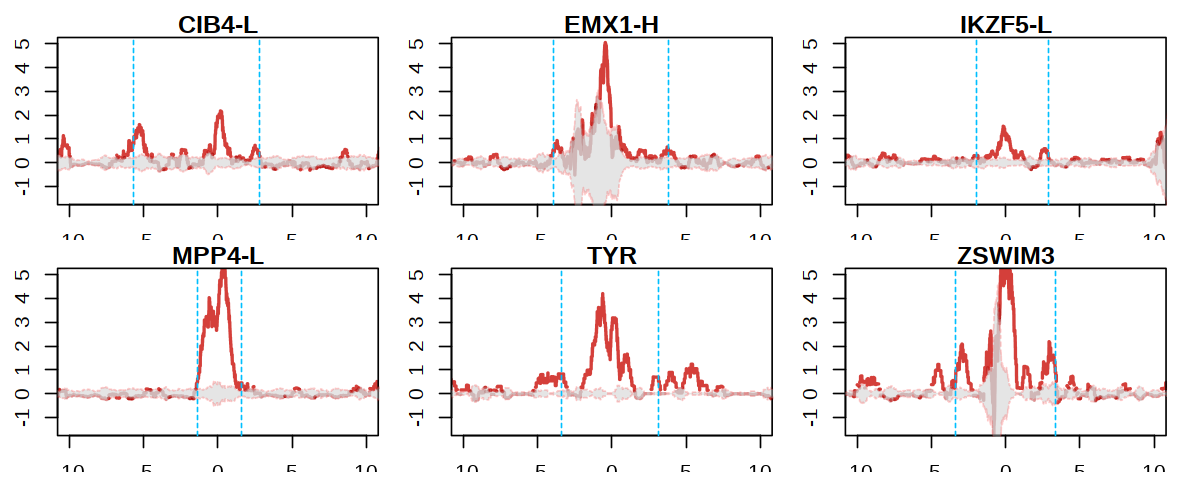

In [11]:

psize(10,4)
t2_<-t2%>%wrap_plots(ncol=3)
t2_%>%plot
psize()

# K562

In [12]:
cutSite.mat.step1 <- readRDS('demo_data/cutSite.mat.k562.example.rds')

In [ ]:
t2 <- list()
for(i in ls(cutSite.mat.step1)){
    a <-  quantification_fun(cutSite.mat.step1[[i]],i,ylim_ = c(-1.5,3), 
                           kernel_weight = 25000,plot=TRUE,xmax_=1.5e5,smooth_=TRUE)
    grid.echo()
    t2<-c(t2,grid.grab()%>%as.ggplot%>%list)    
}


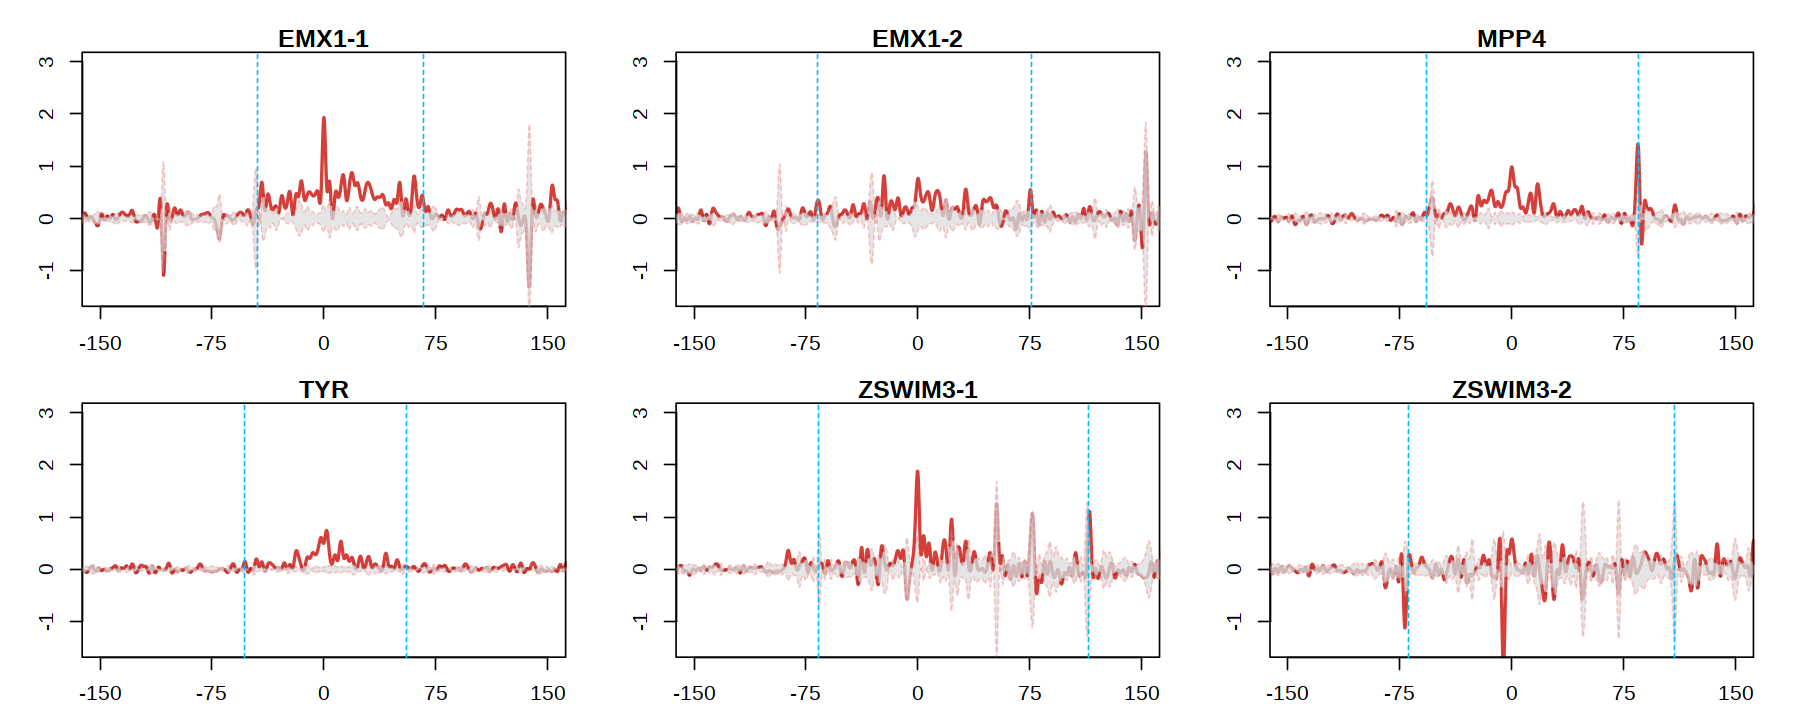

In [14]:
# scale： 5:1 （5*3 : 2*3）
psize(15,6)
t2_<-t2%>%wrap_plots(ncol=3)
t2_%>%plot
psize()

# NIH3T3

In [15]:
cutSite.mat.step1 <- readRDS('demo_data/cutSite.mat.3t3.example.rds')

In [ ]:
t2 <- list()
for(i in ls(cutSite.mat.step1)){
    a <-  quantification_fun(cutSite.mat.step1[[i]],i,ylim_ = c(-1.5,5.5), 
                           kernel_weight = 45000,plot=TRUE,xmax_=1.5e5,smooth_=TRUE)
    grid.echo()
    t2<-c(t2,grid.grab()%>%as.ggplot%>%list)    
}


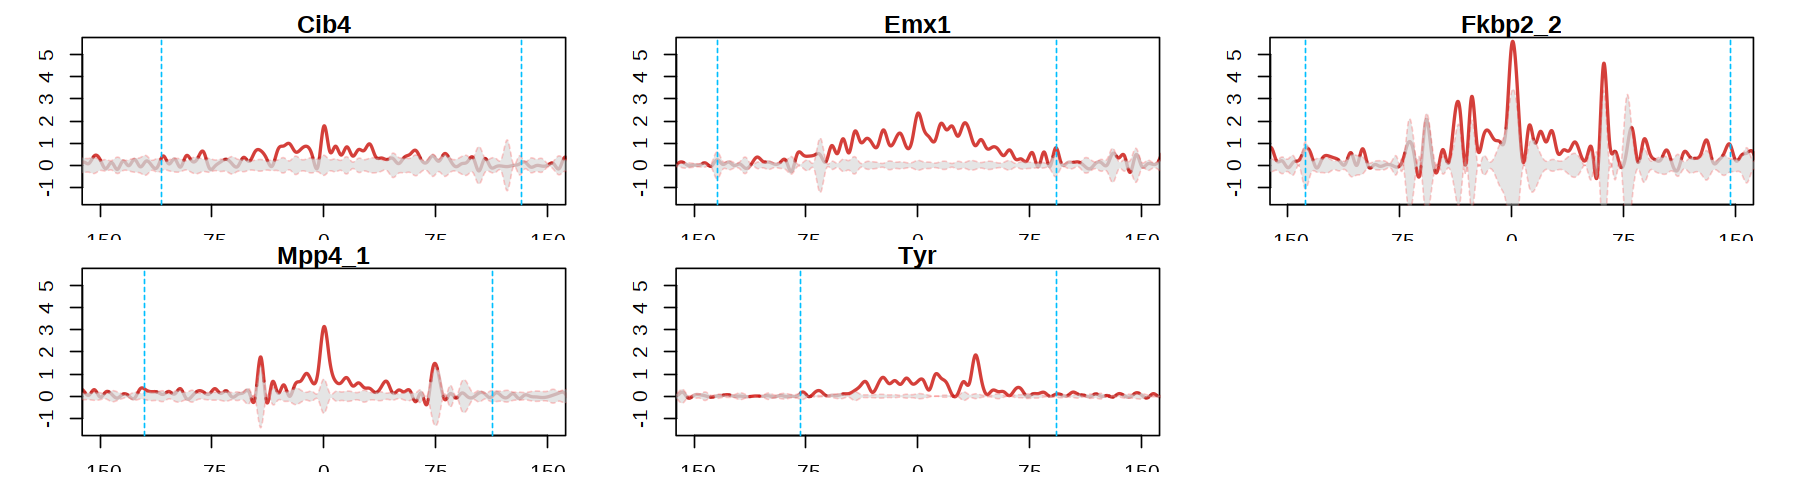

In [17]:
# scale： 5:1 （5*3 : 6*3）
psize(15,4)
t2_<-t2%>%wrap_plots(ncol=3)
t2_%>%plot
psize()

# mESC

In [90]:
cutSite.mat.step1 <- readRDS('cutSite.mat.mesc.example.rds')

In [ ]:
t2 <- list()
for(i in ls(cutSite.mat.step1)){
    a <-  quantification_fun(cutSite.mat.step1[[i]],i,ylim_ = c(-1.5,3.5), 
                           kernel_weight = 50000,plot=TRUE,xmax_=3e5,smooth_=TRUE)
    grid.echo()
    t2<-c(t2,grid.grab()%>%as.ggplot%>%list)    
}


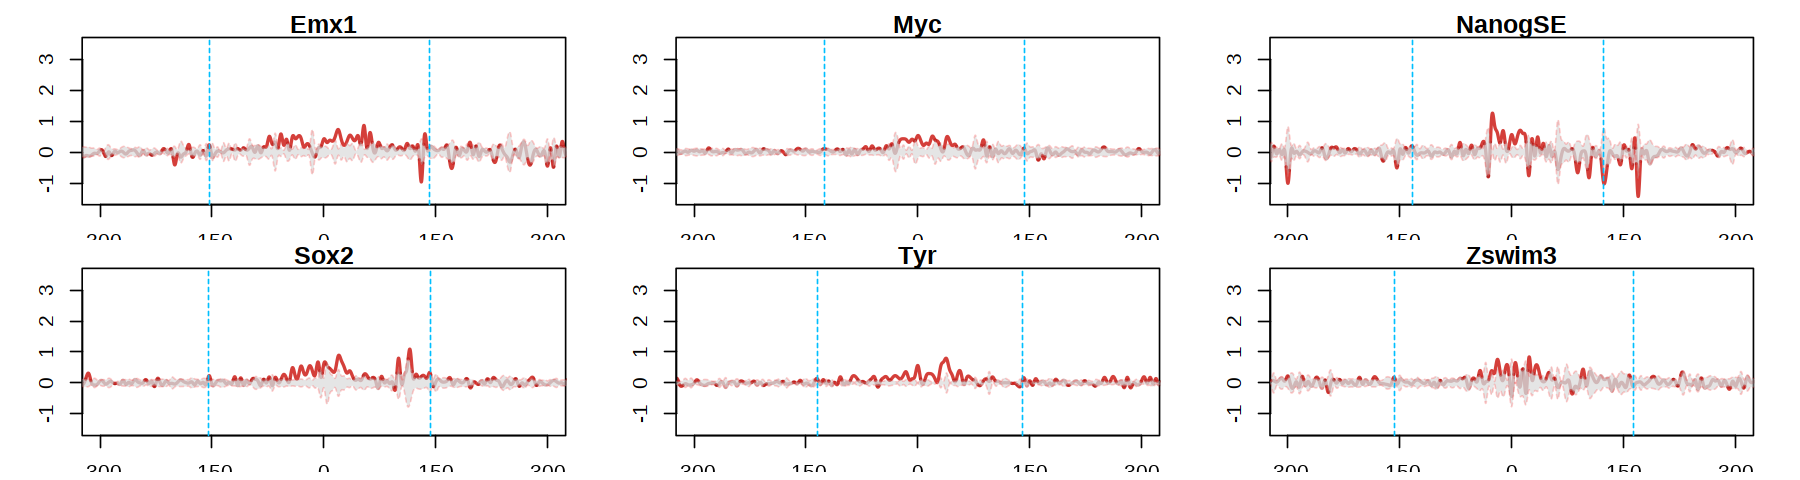

In [88]:
# scale： 5:1 （5*3 :4*3）
psize(15,4)
t2_<-t2%>%wrap_plots(ncol=3)
t2_%>%plot
psize()